# Project 2: Data Analysis of HDB Resale Prices
<hr style="height:5px;border:none;color:gray;background-color:black;">

## Part 3: Preprocessing, Modelling and Kaggle Submission

### Contents:
- [Preprocessing & Modelling](#Preprocessing-&-Modelling)
- [Model Performance](#Model-Performance)
- [LINE Assumptions](#LINE-Assumptions)
- [Analysing Coefficients](#Analysing-Coefficients)
- [Conclusion](#Conclusion)

## Preprocessing & Modelling
<hr style="height:2px;border:none;color:gray;background-color:gray;">

<b>Thought Process:</b>
1. Used Linear Regression + Features A without tuning any hyperparamaters
2. Used Linear Regression + Features A while tuning hyperparameters
3. Used Linear Regression + Features B while tuning hyperparameters (read that tall flats with greenery fetch higher prices)
4. Used Linear Regression + RidgeCV + Features B while tuning hyperparameters
5. Used Linear Regression + ElasticNet + Features B while tuning hyperparameters
6. Used Linear Regression + Polynomial Degree 2 + Features B while tuning hyperparameters
7. Used Linear Regression + Polynomial Degree 2 + Features C while tuning hyperparameters (less features since some features are not important from model 4)
8. Used Linear Regression + Polynomial Degree 2 + Features D while tuning hyperparameters (took away school names and cutoff point from Model 7)

<b>Notes:</b>
- I did not proceed to do Linear Regression + LassoCV since the model in 5 had an L1 ratio of 0.9 which is very close to a Lasso model.
- I also did not want to pursue polynomials of higher degrees since it might lead to an overfitting model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../datasets/clean_train.csv', low_memory=False)

In [3]:
features_A=["town", "floor_area_sqm", "mid", "hdb_age", "market_hawker", 
          "commercial", "multistorey_carpark", "mall_nearest_distance", 
          "hawker_food_stalls", "hawker_market_stalls", "mrt_nearest_distance", 
          "pri_sch_nearest_distance", "pri_sch_name", "sec_sch_name", "tranc_year", 
          "flat_type", "flat_model", "planning_area"]

In [4]:
features_B=["town", "floor_area_sqm", "mid", "hdb_age", "market_hawker", 
          "commercial", "multistorey_carpark", "mall_nearest_distance", 
          "hawker_food_stalls", "hawker_market_stalls", "mrt_nearest_distance", 
          "pri_sch_nearest_distance", "pri_sch_name", "sec_sch_name", "tranc_year", 
          "flat_type", "flat_model", "max_floor_lvl", "planning_area", "cutoff_point"]

In [5]:
features_C=["town", "floor_area_sqm", "mid", "hdb_age", "commercial", "mall_nearest_distance", 
          "hawker_food_stalls", "hawker_market_stalls", "mrt_nearest_distance", 
          "pri_sch_nearest_distance", "pri_sch_name", "sec_sch_name", "tranc_year", 
          "flat_type", "flat_model", "max_floor_lvl", "planning_area", "cutoff_point"]

In [6]:
features_D=["town", "floor_area_sqm", "mid", "hdb_age", "commercial", "mall_nearest_distance", 
          "hawker_food_stalls", "hawker_market_stalls", "mrt_nearest_distance", 
          "pri_sch_nearest_distance", "tranc_year", "flat_type", "flat_model", "max_floor_lvl"]

In [7]:
# create user defined function to remove outliers where z_score < threshold
def RemoveOutliers(df, threshold):
    numeric_cols = df.select_dtypes(include=[np.number])
    z_scores = np.abs(stats.zscore(numeric_cols))
    return df[(z_scores < threshold).all(axis=1)]

In [8]:
# create user defined function that takes in the pipeline and parameter grid if any and chosen features
# the no of Kfolds is fixed at 8 and the scoring used is negative root rmse

def train_model(df, model_no, features, model_name):
    
    X = df[features]
    y = df['resale_price']
    
    X.columns = X.columns.str.lower()

    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(include=['object']).columns

    mall_distance_col = ['mall_nearest_distance']
    other_num_cols = [col for col in num_cols if col != 'mall_nearest_distance']

    mall_distance_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    other_num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', MinMaxScaler())
    ])

    cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('mall_distance', mall_distance_pipeline, mall_distance_col),
            ('other_num', other_num_pipeline, other_num_cols),
            ('cat', cat_pipeline, cat_cols)
        ])
    
    # create different pipelines for different models
    linear_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    ridgecv_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], store_cv_values=True))
    ])
    
    ridge_poly_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=2)),
        ('regressor', Ridge())
    ])

    elastic_net_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet(max_iter=20_000))
    ])
    
    # create parameter grids if applicable for different models
    linear_param_grid = {
        'regressor__fit_intercept': [True, False]
    }
    
    elastic_param_grid = {
        'regressor__alpha': [0.05, 0.1, 0.2, 0.3, 0.5],
        'regressor__l1_ratio': [0.2, 0.4, 0.6, 0.8, 0.9]
    }  
    
    ridge_poly_param_grid = {
        'regressor__alpha': [0.1, 1.0, 10.0]
    }
    
    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    if model_no == 1:
        pipeline = linear_pipeline
        param_grid = {}
        
    elif model_no == 2:
        pipeline = linear_pipeline
        param_grid = linear_param_grid
        
    elif model_no == 3:
        pipeline = ridgecv_pipeline
        param_grid = {}
    
    elif model_no == 4:
        pipeline = elastic_net_pipeline
        param_grid = elastic_param_grid   
    
    elif model_no == 5:
        pipeline = ridge_poly_pipeline
        param_grid = ridge_poly_param_grid
        
    else:
        print('Invalid model number.')
    
    # do a gridsearch
    grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=8), scoring='neg_root_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    
    model = grid_search.best_estimator_
    y_pred = model.predict(X_test)
    
    if model_no == 3:
        model.fit(X_train, y_train)
        print(f'Best alpha: {model.named_steps["regressor"].alpha_}')
    
    # get coefficients
    coefficients = model.named_steps['regressor'].coef_
    
    # get features used
    num_features = ['mall_nearest_distance'] + [col for col in other_num_cols]
    cat_transformer = model.named_steps['preprocessor'].named_transformers_['cat']
    cat_features = cat_transformer.named_steps['encoder'].get_feature_names_out(cat_cols)
    all_features = np.array(num_features + list(cat_features))
    
    # print RMSE and R2 score
    rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    
    print(f"Best parameters for {pipeline.steps[-1][0]}: {grid_search.best_params_}")
    print(f"Best score for {pipeline.steps[-1][0]}: {-grid_search.best_score_}")
    
    print("\nRoot Mean Squared Error (Train):", rmse_train)
    print("Root Mean Squared Error (Test):", rmse_test)
    print("\nR2 Score (Train):", r2_train)
    print("R2 Score (Test):", r2_test)
    
    # generate predictions for Kaggle
    df_test = pd.read_csv('../datasets/test.csv', low_memory=False)
    ID = df_test['id']
    
    df_test.columns = df_test.columns.str.lower()
    
    df_test = df_test[features]

    df_test = df_test[X_train.columns]

    df_test.replace('N', 0, inplace=True)
    df_test.replace('Y', 1, inplace=True)

    predictions = model.predict(df_test)
    submission = pd.DataFrame({'Id': ID, 'Predicted': predictions})
    submission.to_csv(f'../submissions/{model_name}_submission.csv', index=False)
    
    return y_test, y_pred, coefficients, all_features

In [9]:
#remove outliers before preprocessing and modelling
no_outliers_df = RemoveOutliers(df, 3)

### Model 1: Baseline Linear Regression

In [16]:
y_test_1, y_pred_1, coeff_1, features_1 = train_model(no_outliers_df, 1, features_A, 'Linear')

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Best parameters for regressor: {}
Best score for regressor: 38858.99702515498

Root Mean Squared Error (Train): 38675.502655453434
Root Mean Squared Error (Test): 38765.39198299785

R2 Score (Train): 0.8872718694932928
R2 Score (Test): 0.8868950727038339


### Model 2: Tuned Linear Regression 1

In [17]:
y_test_2, y_pred_2, coeff_2, features_2 = train_model(no_outliers_df, 2, features_A, 'Tuned_Linear_1')

Fitting 8 folds for each of 2 candidates, totalling 16 fits
Best parameters for regressor: {'regressor__fit_intercept': False}
Best score for regressor: 38858.87730600173

Root Mean Squared Error (Train): 38675.50302211992
Root Mean Squared Error (Test): 38774.440231802284

R2 Score (Train): 0.887271867355835
R2 Score (Test): 0.8868422667907683


### Model 3: Tuned Linear Regression 2

In [18]:
y_test_3, y_pred_3, coeff_3, features_3 = train_model(no_outliers_df, 2, features_B, 'Tuned_Linear_2')

Fitting 8 folds for each of 2 candidates, totalling 16 fits
Best parameters for regressor: {'regressor__fit_intercept': False}
Best score for regressor: 38554.83792154634

Root Mean Squared Error (Train): 38371.81953237191
Root Mean Squared Error (Test): 38525.650409995265

R2 Score (Train): 0.8890352197173084
R2 Score (Test): 0.8882897241463878


### Model 4: RidgeCV Regression

In [21]:
y_test_4, y_pred_4, coeff_4, features_4 = train_model(no_outliers_df, 3, features_B, 'RidgeCV')

Fitting 8 folds for each of 1 candidates, totalling 8 fits
Best alpha: 0.1
Best parameters for regressor: {}
Best score for regressor: 38554.76313208755

Root Mean Squared Error (Train): 38371.92969874105
Root Mean Squared Error (Test): 38517.90090710459

R2 Score (Train): 0.8890345825515631
R2 Score (Test): 0.8883346610664906


### Model 5: Elastic Net

In [22]:
y_test_5, y_pred_5, coeff_5, features_5 = train_model(no_outliers_df, 4, features_B, 'ElasticNet')

Fitting 8 folds for each of 25 candidates, totalling 200 fits
Best parameters for regressor: {'regressor__alpha': 0.05, 'regressor__l1_ratio': 0.9}
Best score for regressor: 44090.575797401965

Root Mean Squared Error (Train): 43996.017601111664
Root Mean Squared Error (Test): 43973.287894138535

R2 Score (Train): 0.8541229053010158
R2 Score (Test): 0.8544637958091559


### Model 6: Polynomial Ridge Regression (B)

In [12]:
y_test_6, y_pred_6, coeff_6, features_6 = train_model(no_outliers_df, 5, features_B, 'PolyRidgeB')

Fitting 8 folds for each of 3 candidates, totalling 24 fits
Best parameters for regressor: {'regressor__alpha': 1.0}
Best score for regressor: 25292.403546527123

Root Mean Squared Error (Train): 23961.03203297873
Root Mean Squared Error (Test): 25213.955697394933

R2 Score (Train): 0.9567315427528317
R2 Score (Test): 0.9521507498607049


### Model 7: Polynomial Ridge Regression (C)

In [11]:
y_test_7, y_pred_7, coeff_7, features_7 = train_model(no_outliers_df, 5, features_C, 'PolyRidgeC')

Fitting 8 folds for each of 3 candidates, totalling 24 fits
Best parameters for regressor: {'regressor__alpha': 1.0}
Best score for regressor: 25294.976748681154

Root Mean Squared Error (Train): 23960.7024993197
Root Mean Squared Error (Test): 25213.88875971564

R2 Score (Train): 0.9567327328781126
R2 Score (Test): 0.9521510039194926


### Model 8: Polynomial Ridge Regression (D)

In [10]:
y_test_8, y_pred_8, coeff_8, features_8 = train_model(no_outliers_df, 5, features_D, 'PolyRidgeD')

Fitting 8 folds for each of 3 candidates, totalling 24 fits
Best parameters for regressor: {'regressor__alpha': 0.1}
Best score for regressor: 28741.658043834585

Root Mean Squared Error (Train): 28295.012401304946
Root Mean Squared Error (Test): 28849.558755472237

R2 Score (Train): 0.9396634952399943
R2 Score (Test): 0.9373571489171859


## Model Performance
<hr style="height:2px;border:none;color:gray;background-color:gray;">

### Summary

The following table is a summary of the models used with their R2 score and root mean squared error (RMSE).

| Model| R2 Score<br>(Train) | R2 Score<br>(Test) | RMSE<br>(Train) | RMSE<br>(Test) | Features & Parameters (if any) | Model Fit |
|------|---------------------|--------------------|-----------------|----------------|--------------------------------|-----------|
| Baseline Linear Regression  | 0.8872 | 0.8868 | 38675 | 38526 | Feature A | Good Fit |
| Tuned Linear Regression 1   | 0.8872 | 0.8868 | 38675 | 38773 | Feature A, regressor__fit_intercept': False| Good Fit |
| Tuned Linear Regression 2   | 0.8890 | 0.8882 | 38371 | 38526 | Feature B, regressor__fit_intercept': False| Good Fit |    
| RidgeCV Regression          | 0.8890 | 0.8883 | 38371 | 38517 | Feature B, Best alpha = 0.1 | Good Fit |
| Elastic Net                 | 0.8541 | 0.8544 | 43996 | 43973 | Feature B, Best alpha = 0.05, L1 Ratio = 0.9 | Underfit |   
| Polynomial Ridge Regression | 0.9567 | 0.9521 | 23961 | 25213 | Feature B, Degree = 2, Best alpha = 1.0 | Good Fit |
| Polynomial Ridge Regression | 0.9567 | 0.9521 | 23960 | 25213 | Feature C, Degree = 2, Best alpha = 1.0 | Good Fit |
| Polynomial Ridge Regression | 0.9400 | 0.9377 | 28199 | 28765 | Feature D, Degree = 2, Best alpha = 0.1 | Good Fit |

### Worst Model:

Out of the 10 models, the <b>elastic net model</b> seems to have the worst performance.

### Best Model:

Out of the 10 models, the <b>polynomial ridge regression model with Feature B </b> has the best performance on Kaggle.<br>
However, I will choose the <b>polynomial ridge regression model with Feature D </b> since it has the least number of features and does not include school names and planning areas. This model is better for my problem statement as we cannot be building schools to drive up the prices of resale flats. It's simply not feasible. Furthermore, the chosen model runs a lot faster than the best performing model.

## LINE Assumptions
<hr style="height:2px;border:none;color:gray;background-color:gray;">

### 1. Linearity (L)

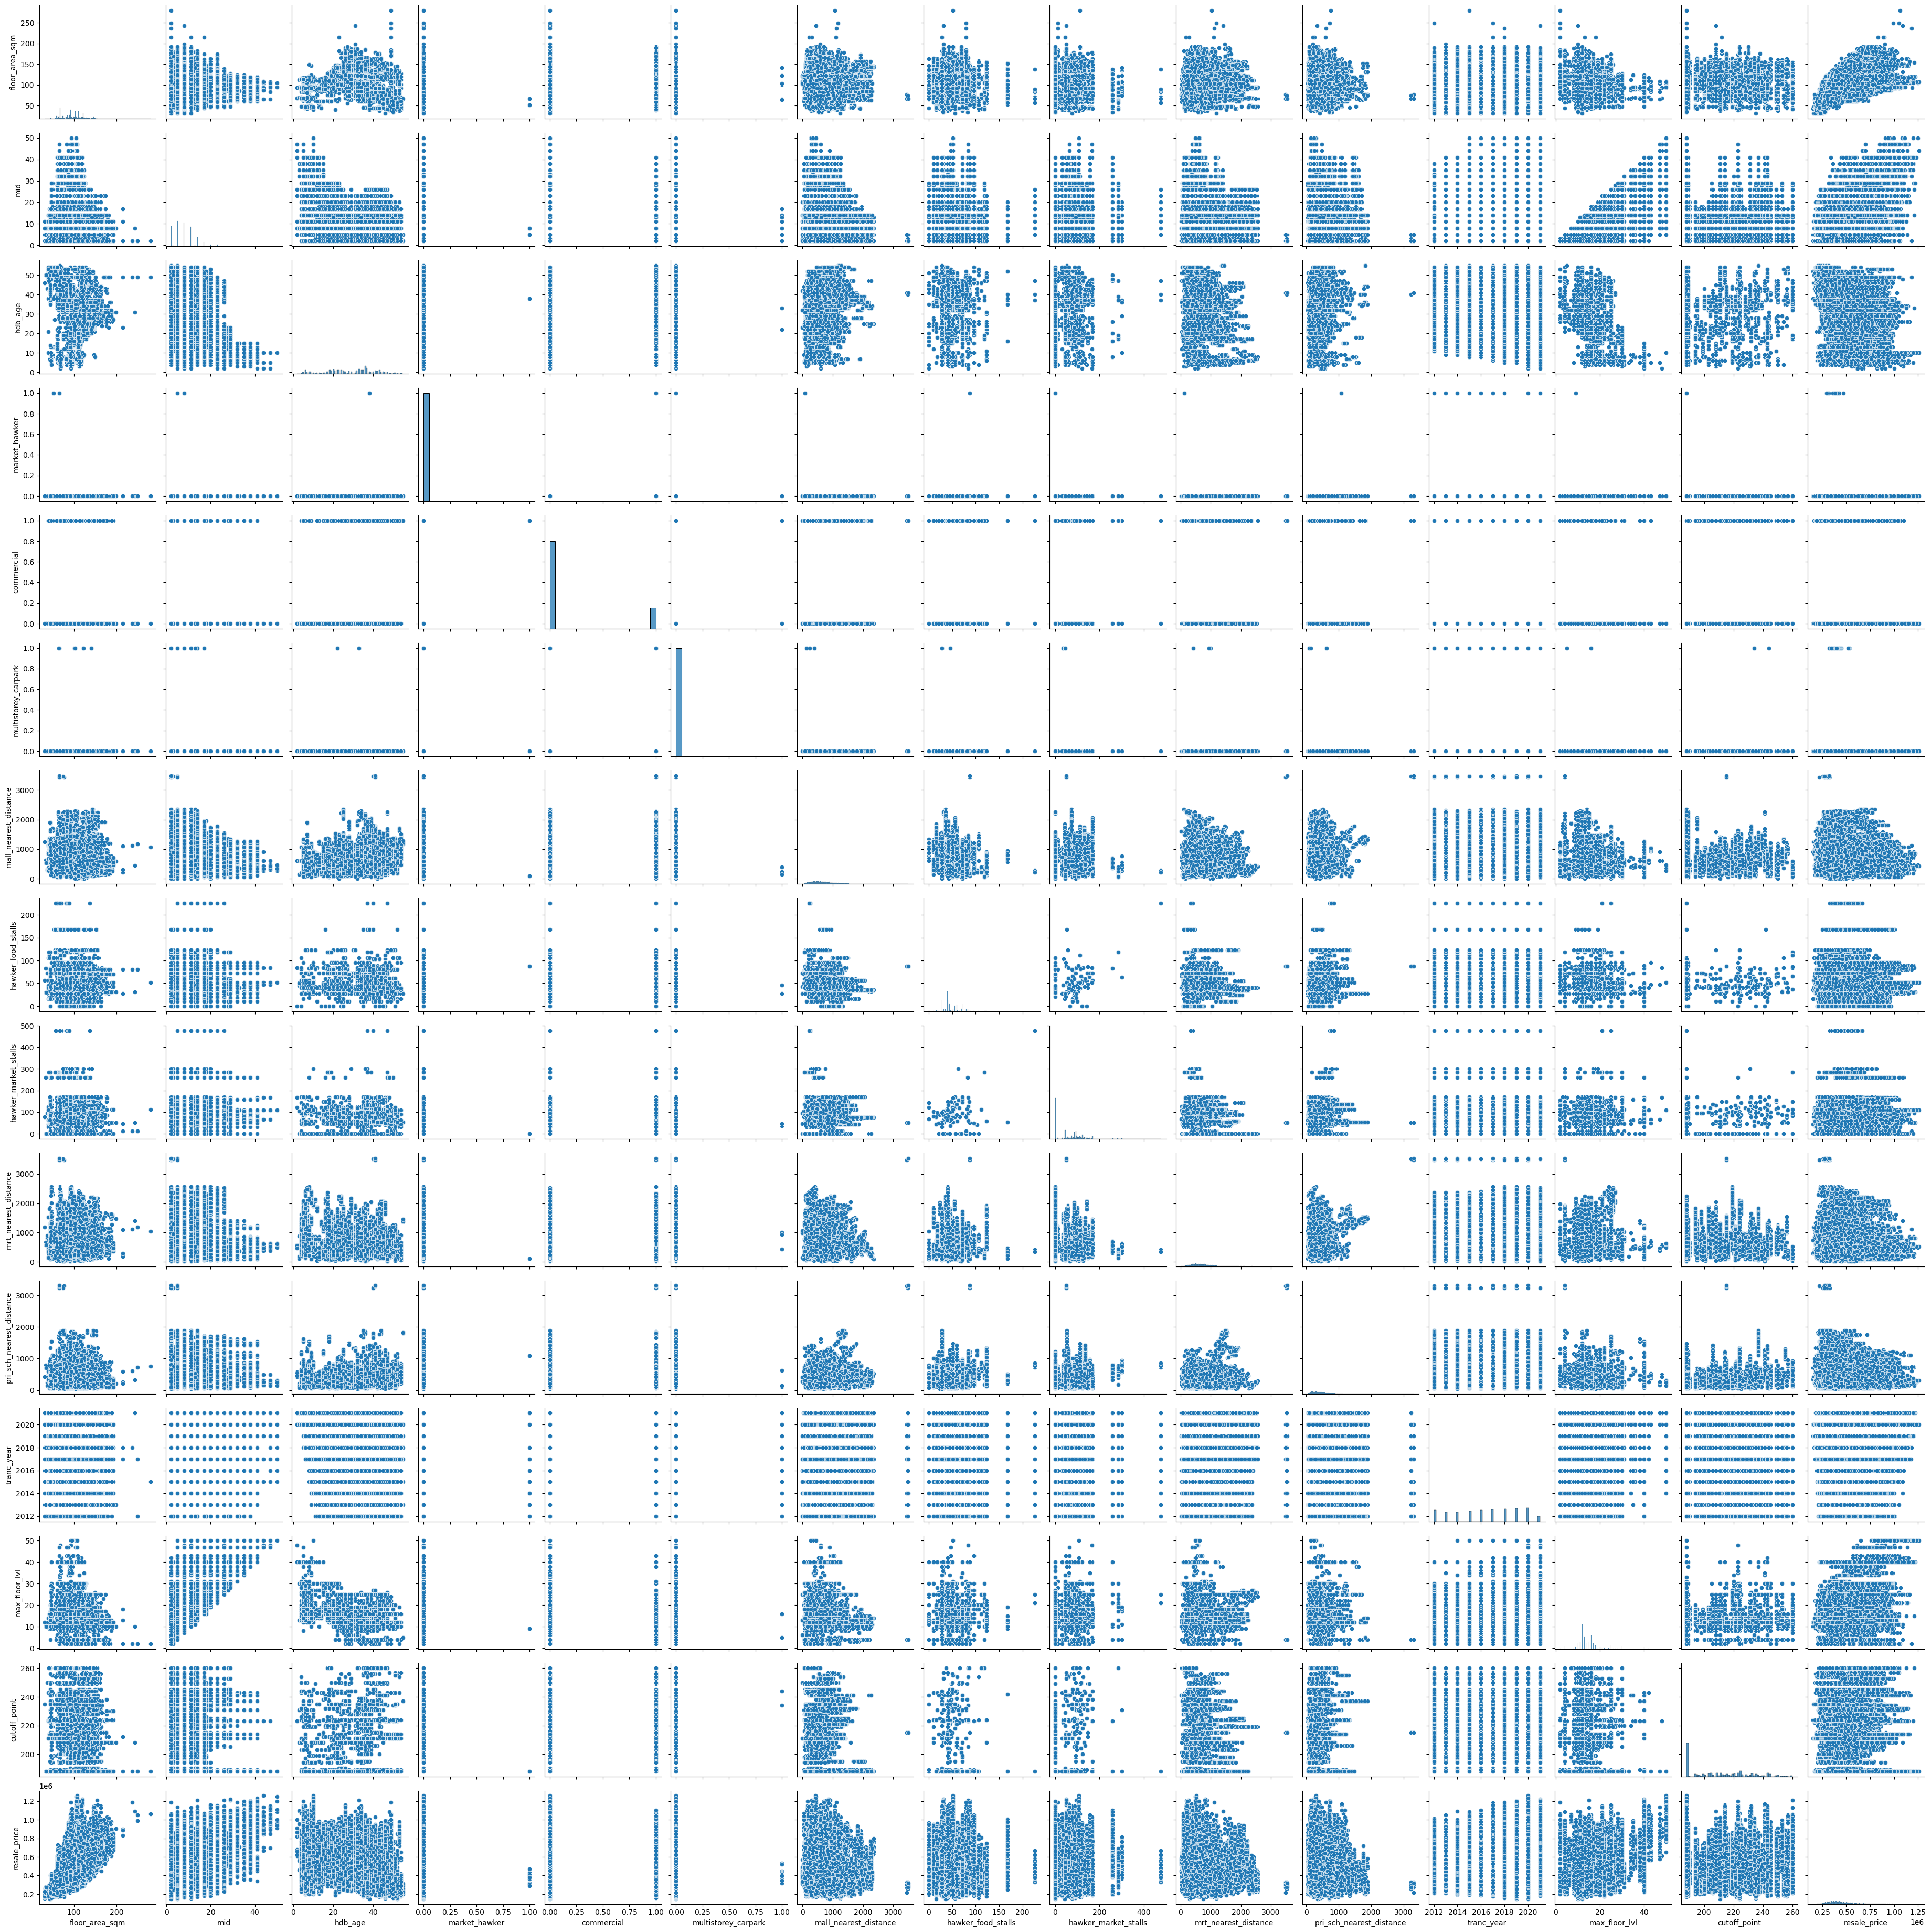

In [13]:
# chose to show features_B since it has the most number of features
X = df[features_B]
y = df['resale_price']
sns.pairplot(pd.merge(X, y, left_index = True, right_index = True))
plt.show()

### 2. Independence (I)

Independence is assumed.

### 3. Normality (N) and Equal Variance (E)

In [14]:
# create function to plot histogram of residudla
def plot_residuals(y_test, y_pred, title):
    residuals = y_test - y_pred
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # check for normality
    sns.histplot(residuals, bins=50, ax=axes[0], kde=True, color='mediumturquoise')
    axes[0].set_xlabel('Residuals')
    axes[0].set_title('Histogram of Residuals')
    
    # check for equal variance
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[1], color='lightcoral')
    axes[1].axhline(y=0, color='navy', linestyle='--')
    axes[1].set_xlabel('Predictions')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residuals vs Predictions')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    print('\n')

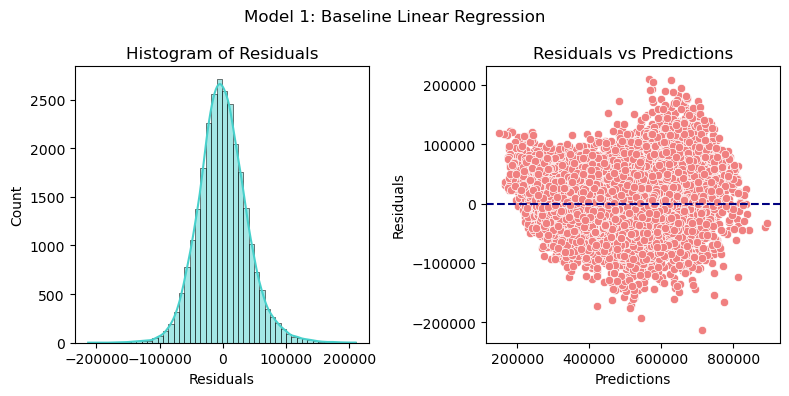

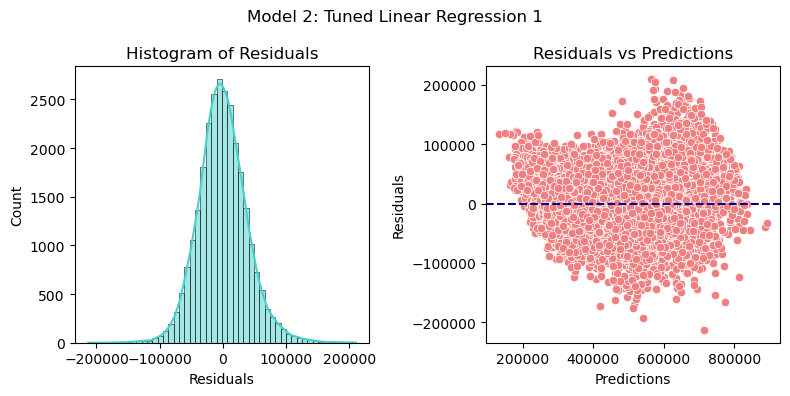

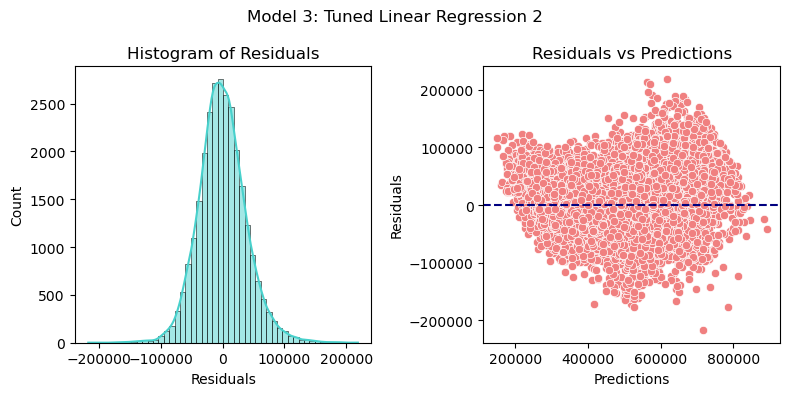

In [19]:
# this part only shows the plots for the linear regression without regularization

y_test_list = [y_test_1, y_test_2, y_test_3]
y_pred_list = [y_pred_1, y_pred_2, y_pred_3]
title_list = ['Model 1: Baseline Linear Regression',
              'Model 2: Tuned Linear Regression 1',
              'Model 3: Tuned Linear Regression 2'
             ]

for i in range(0,3):
    y_test = y_test_list[i]
    y_pred = y_pred_list[i]
    title = title_list[i]
    plot_residuals(y_test, y_pred, title)

### Observations:

1. Not all features have a linear relationship with the target.
2. All residuals are normally distributed.
3. However, the variance is not equal.

## Analysing Coefficients
<hr style="height:2px;border:none;color:gray;background-color:gray;">

In this section, I plot the coefficients from the different models and used the results from the RidgeCV model to reduce the number of features. 

In [26]:
coefficients_list = [coeff_1, coeff_2, coeff_3, coeff_4, coeff_5, coeff_6, coeff_7, coeff_8]
features_name_list = [features_1, features_2, features_3, features_4, features_5, features_6, features_7, features_8]
model_name_list = ['Linear', 'Tuned Linear 1', 'Tuned Linear 2', 'RidgeCV',
                   'Elastic Net', 'Polynomial Ridge (B)', 'Polynomial Ridge (C)',
                   'Polynomial Ridge (D)']

In [24]:
def plot_coeff(coefficients, features_name, N, name):
    coef_df = pd.DataFrame(list(zip(coefficients,features_name)), columns=['coefficient', 'feature_name'])
    sorted_coef_df = coef_df.sort_values(by='coefficient', key=lambda col: col.abs(), ascending=False)
    
    fig, axes = plt.subplots(1,2,figsize=(16, 8))

    # Plot Absolute Coefficients
    axes[0].barh(sorted_coef_df['feature_name'].head(N), np.abs(sorted_coef_df['coefficient'].head(N)), color='aliceblue', edgecolor='navy')
    axes[0].set_xlabel('Absolute Coefficient Value')
    axes[0].set_ylabel('Feature')
    axes[0].set_title(f'Top {N} Absolute Coefficients for {name} Model')

    #  Plot Coefficients
    axes[1].barh(sorted_coef_df['feature_name'].head(N), sorted_coef_df['coefficient'].head(N), color='lightcoral', edgecolor='darkred')
    axes[1].set_xlabel('Coefficient Value')
    axes[1].set_title(f'Top {N} Coefficients for {name} Model')

    plt.tight_layout()
    plt.show()
    print('\n')

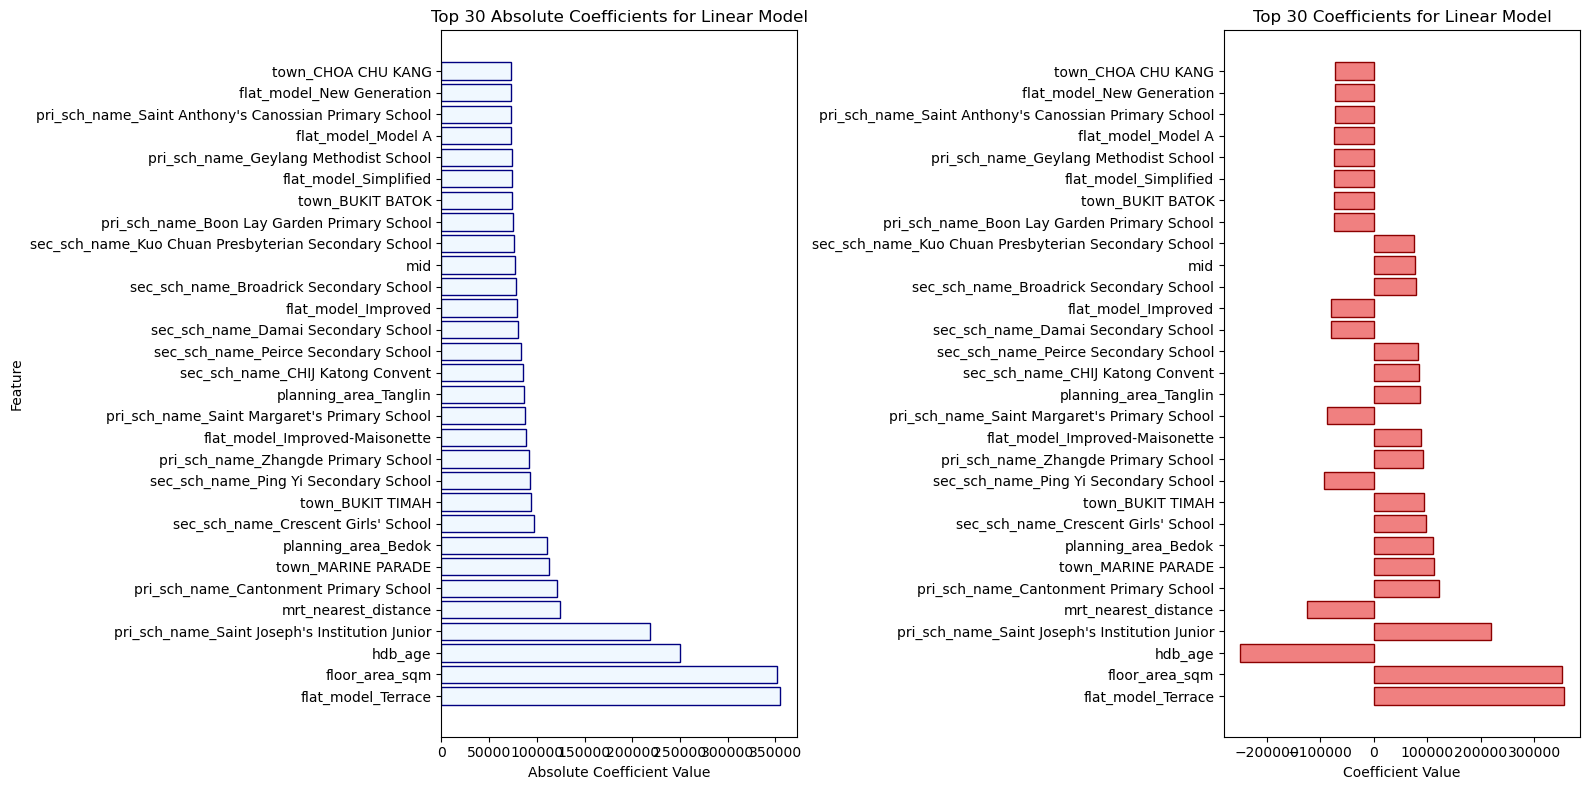

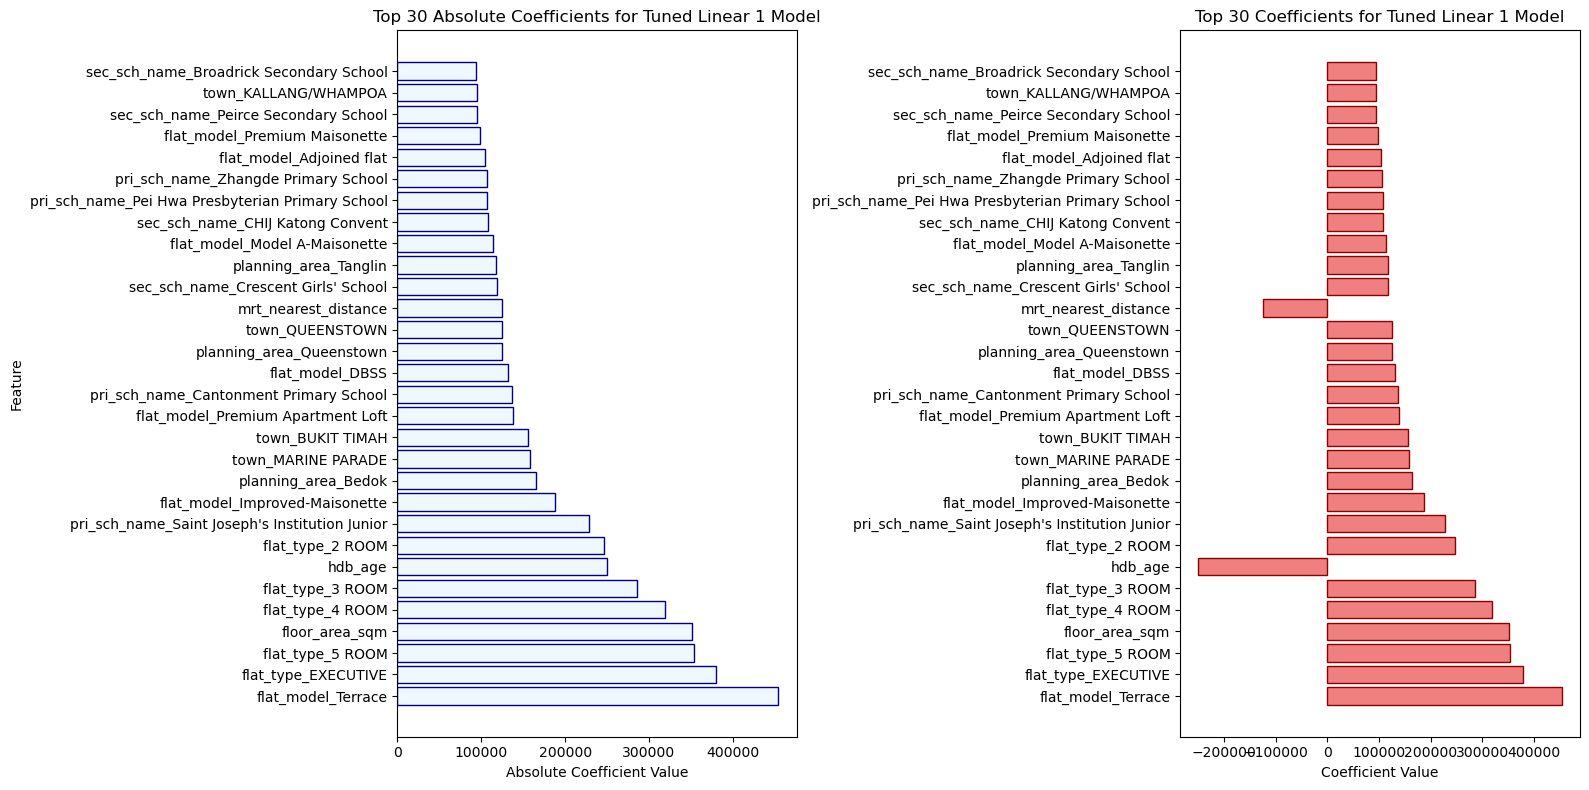

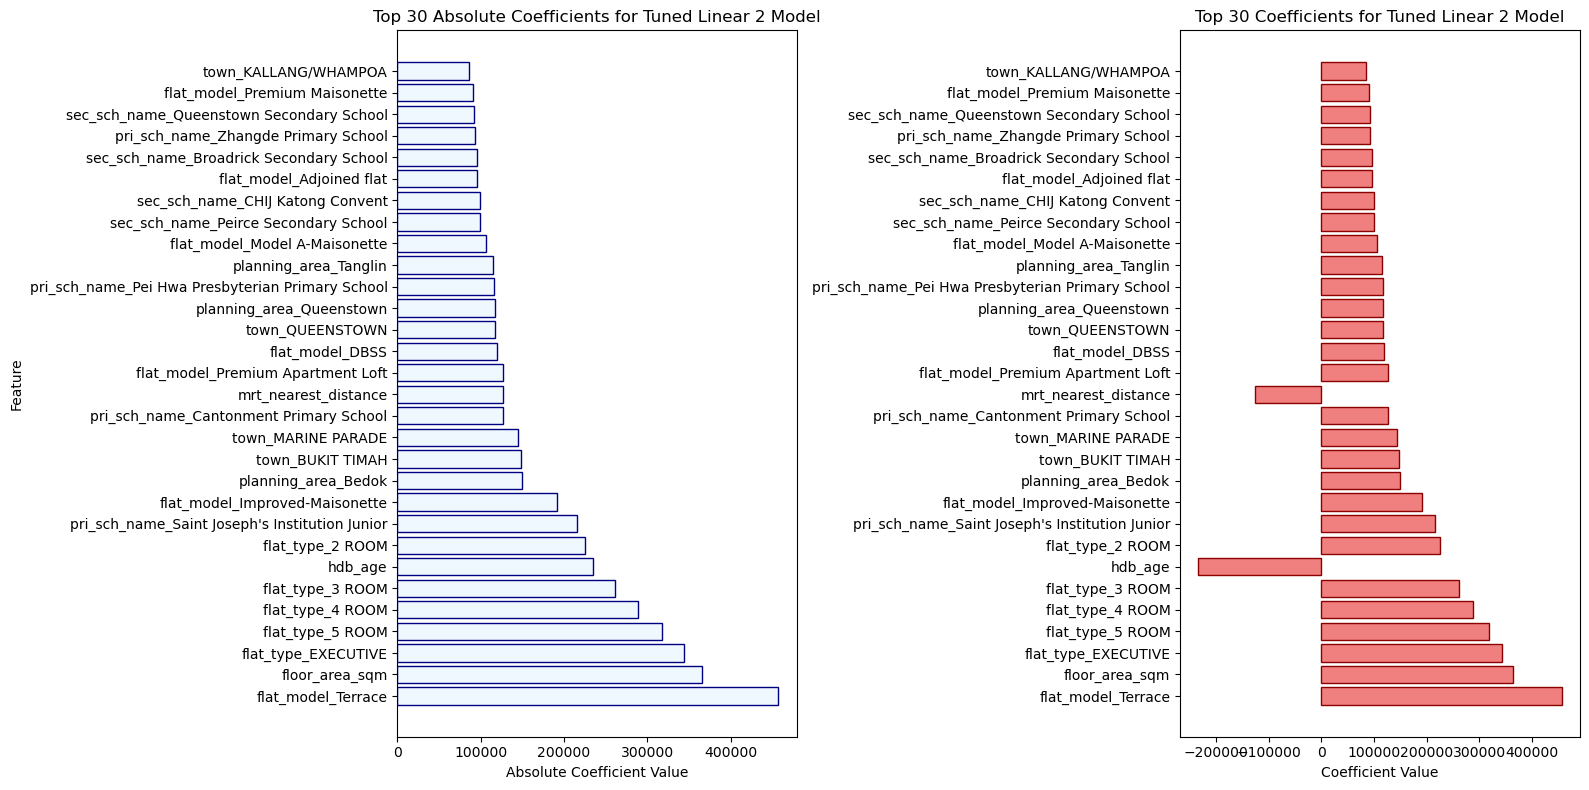

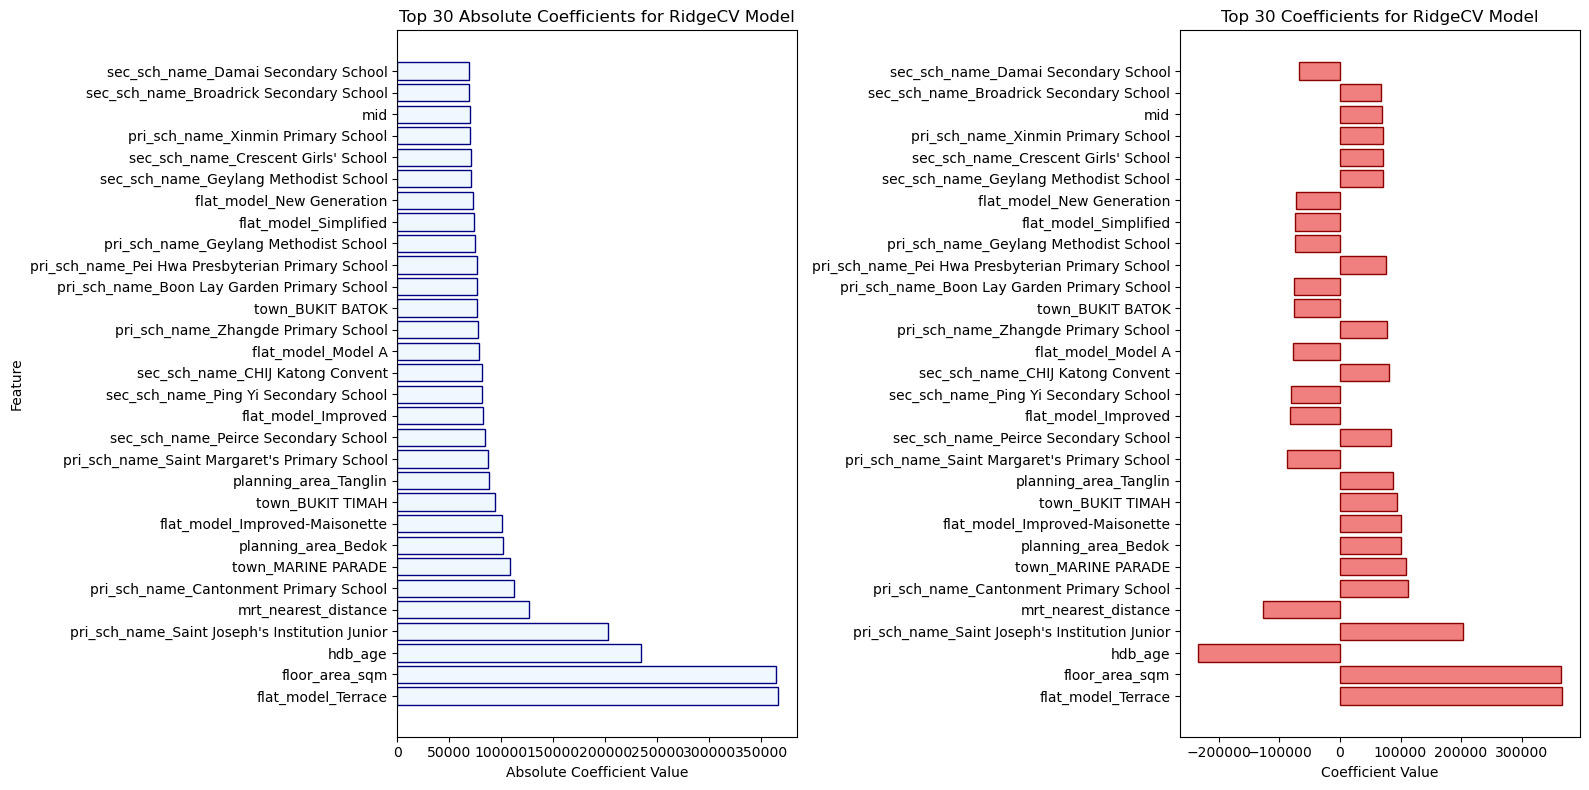

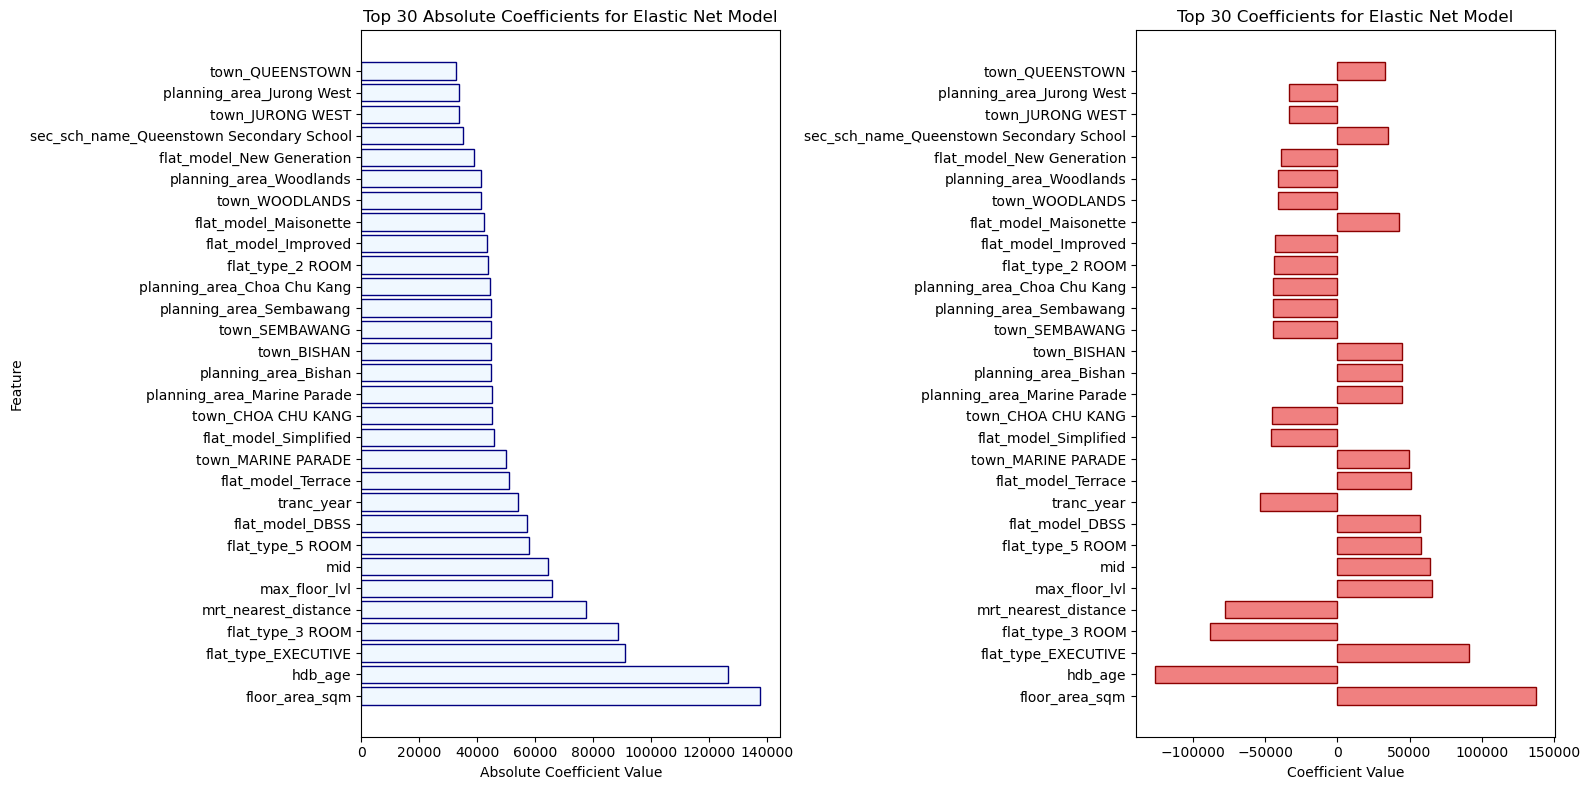

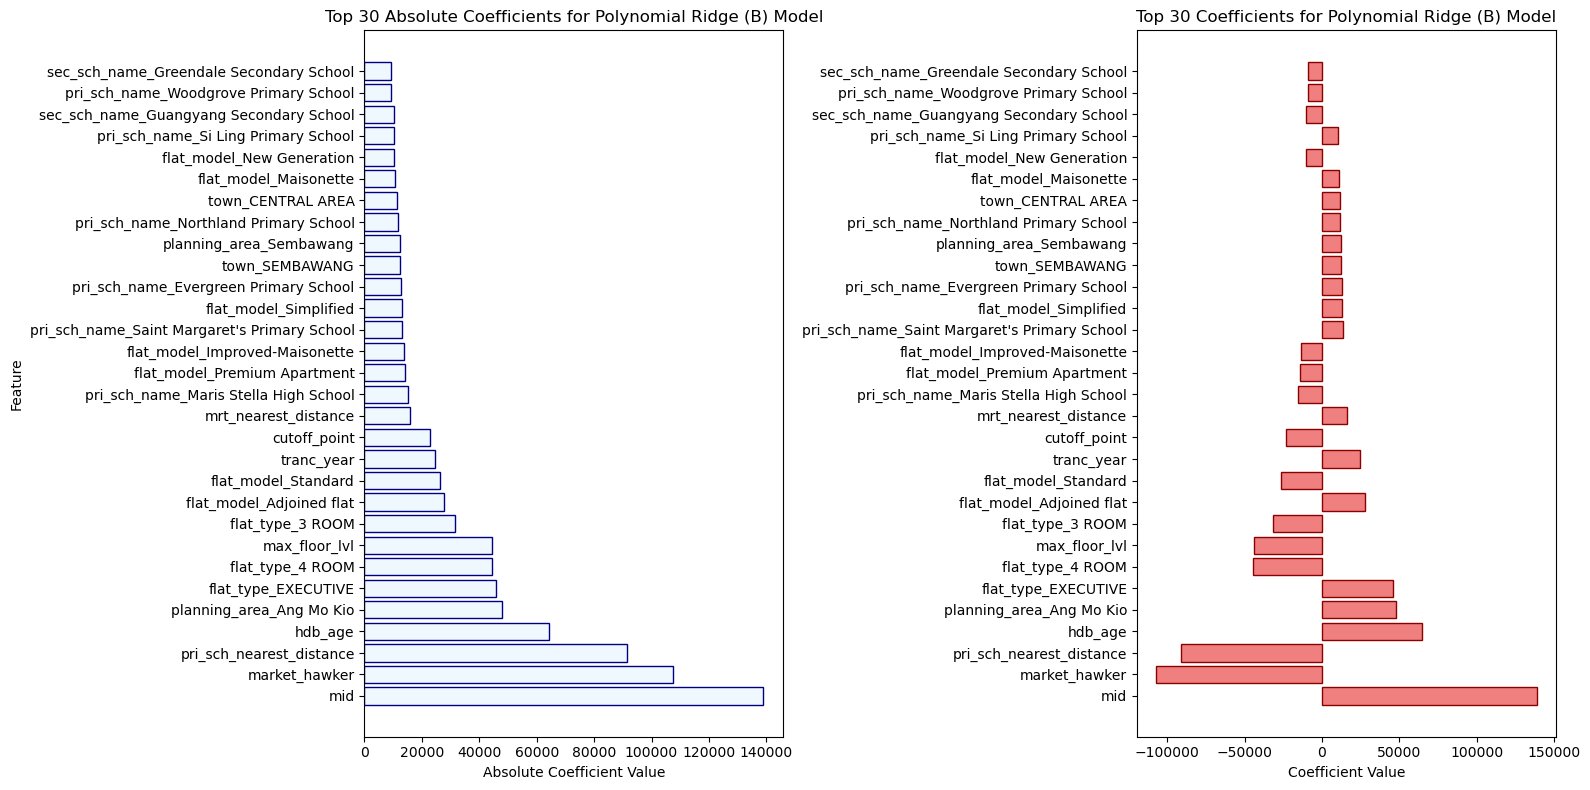

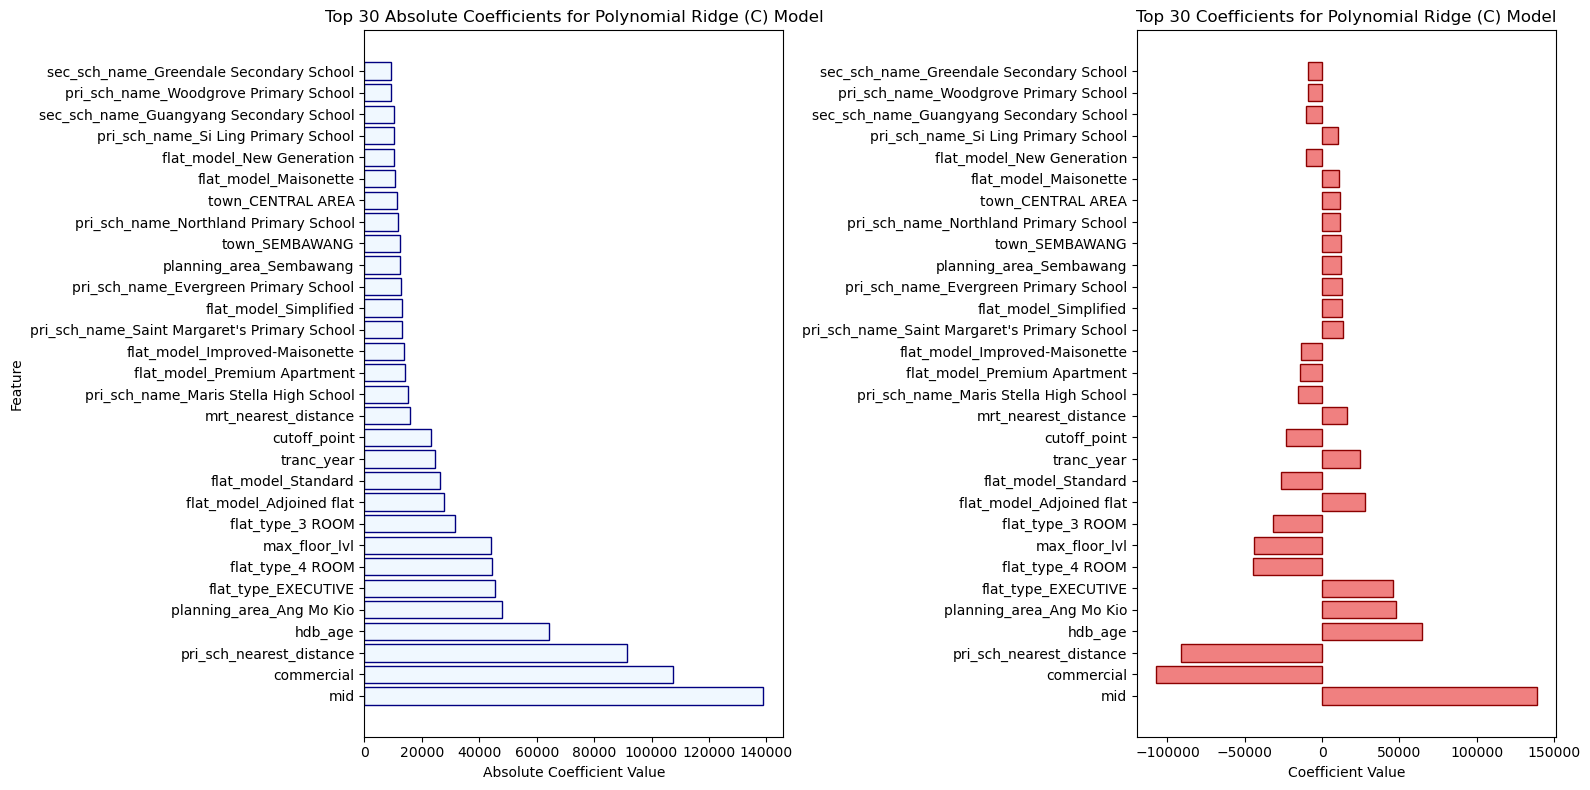

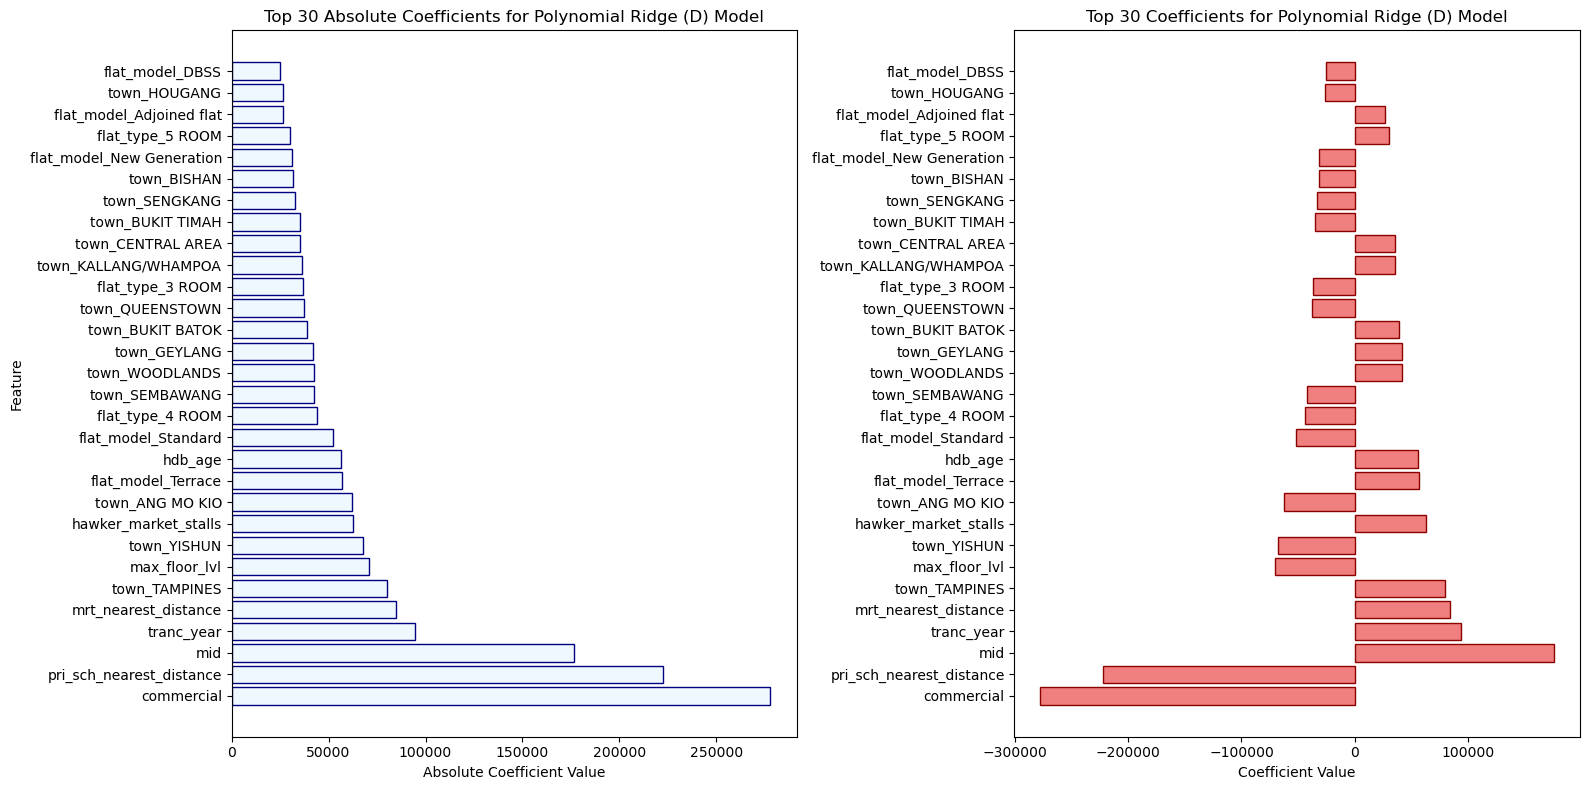

In [27]:
num_features = 30
for i in range(0,8):
    plot_coeff(coefficients_list[i], features_name_list[i], num_features, model_name_list[i])

## Conclusion
<hr style="height:2px;border:none;color:gray;background-color:gray;">

The chosen model is <b>model 8 using Polynomial Degree 2 using Ridge regularisation with Features D</b>. I chose this model because it does not contain school names. From the other models, certain schools are drivers of resale prices. In the context of my problem statement, it does not make sense to build more schools just to drive resale prices up.<br>

From the coefficients, we can conclude the following top 3 drivers (amenities related):
1. Presence of commercial units
2. Number of hawker and market stalls
3. Mrt nearest distance

Building amenities such as MRT stations which makes it convenient for travel and having hawker and market stalls which makes it convenient for dwellers nearby can drive up the resale prices. <br>

However, the presence of commercial units has a negative effect on the resale prices.This could be due to increased noise, traffic, or other factors that might make a residential area less appealing for some buyers. 